In [207]:
import os

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import hist2d
from networkx.classes import neighbors
from skimage.color.tests.test_adapt_rgb import edges_hsv
from sympy import pager_print
from tensorflow import keras
from tensorflow.keras import layers


In [208]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

In [209]:
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep='\t',
    header=None,
    names=['target', 'source']
)
print(citations.shape)

(5429, 2)


In [210]:
citations

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [211]:
column_names = ['paper_id'] + [f'term_{idx}' for idx in range(1433)] + ['subject']
papers = pd.read_csv(
    os.path.join(data_dir, 'cora.content'), sep='\t', header=None, names=column_names,
)

In [212]:
papers

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


In [213]:
papers.subject.value_counts()


subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64

In [214]:
class_values = sorted(papers['subject'].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers['paper_id'].unique()))}

papers['paper_id'] = papers['paper_id'].apply(lambda x: paper_idx[x])
papers['subject'] = papers['subject'].apply(lambda x: class_idx[x])

citations['source'] = citations['source'].apply(lambda x: paper_idx[x])
citations['target'] = citations['target'].apply(lambda x: paper_idx[x])


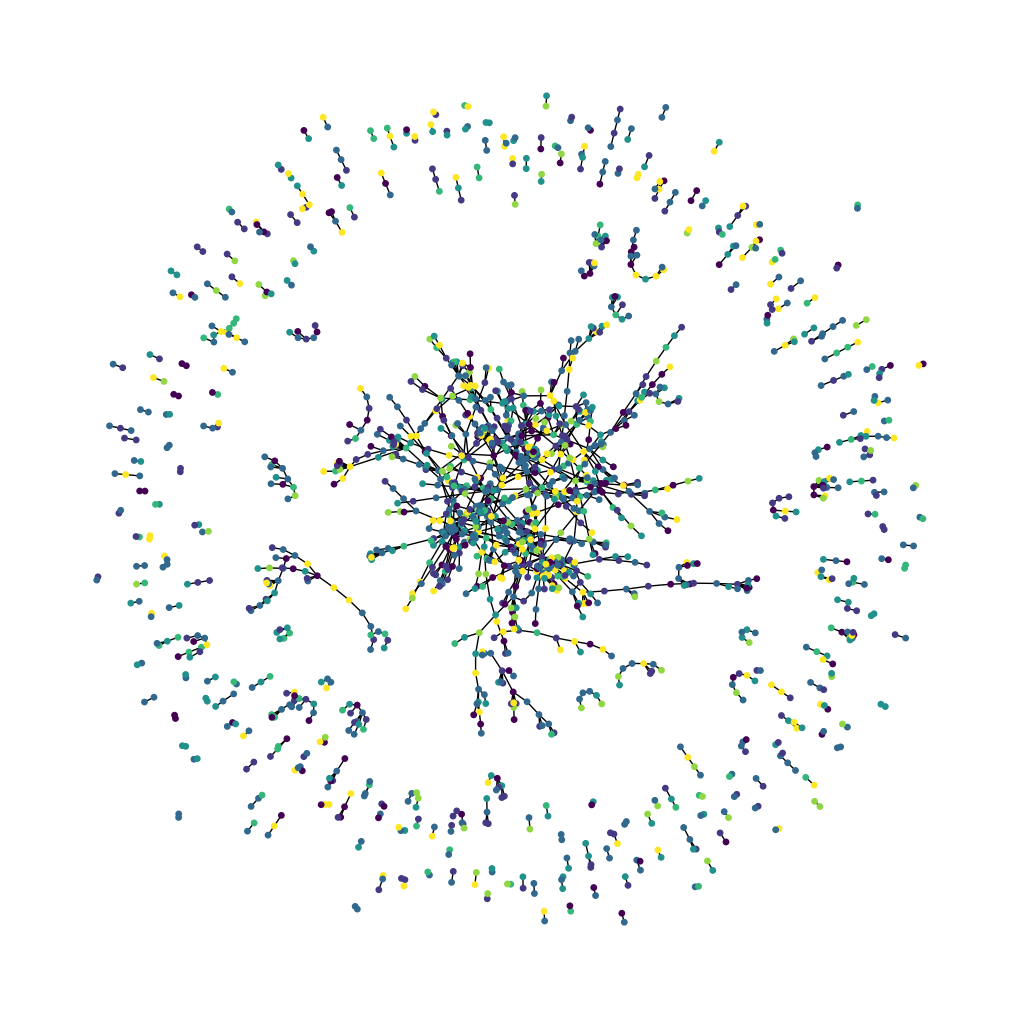

In [215]:
plt.figure(figsize=(10, 10))
colors = papers['subject'].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers['paper_id'].isin(list(cora_graph.nodes))]['subject'])
nx.draw(cora_graph, node_size=15, node_color=subjects)

In [216]:
train_data, test_data = [], []

for _, data in papers.groupby('subject'):
    random_selection = np.random.rand(len(data.index)) <= 0.5
    train_data.append(data[random_selection])
    test_data.append(data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Train data shape:  (1361, 1435)
Test data shape:  (1347, 1435)


In [217]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=63,
        restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping]
    )

    return history


In [218]:
def display_learning_curve(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['loss', 'val_loss'], loc='upper left')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')


    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.legend(['accuracy', 'val_accuracy'], loc='upper left')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')

    plt.show()



In [219]:

def ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation ='gelu'))

    return keras.Sequential(fnn_layers,
                            name=name)

In [220]:
feature_names = list(set(papers.columns) - {'paper_id', 'subject'})
num_features = len(feature_names)
num_classes = len(class_idx)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

y_train = train_data['subject']
y_test = test_data['subject']



In [221]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
        inputs = layers.Input(shape=(num_features,), name='input_features') # takes a feature vector which is of size num features
        x = ffn(hidden_units, dropout_rate, name=f'ffn_block1')(inputs) # creates the first feed forward block
        # this block assumed to include the dense + dropout + activation layers along with hidden units neurons


        #generations 4 residual blocks with the skip connection mechanism and adds the orginal input x to the
        #final output of the fnn black x1
        for block_idx in range(6):
            x1 = ffn(hidden_units, dropout_rate, name=f'ffn_block{block_idx + 2}')(x)

            x = layers.Add(name=f'skip_connection{block_idx + 2}')([x, x1])

        logits = layers.Dense(num_classes, name='logits')(x)

        return keras.Model(inputs=inputs, outputs=logits, name='baseline')
"""
this is a feedforward model which includes skip connections.
this model is designed for the classification of different datapoints and it uses residual connections to do so.
2
"""

'\nthis is a feedforward model which includes skip connections.\nthis model is designed for the classification of different datapoints and it uses residual connections to do so.\n2\n'

In [222]:
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate=0.2)

In [223]:
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 1433)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block1          │ (None, 32)        │     52,804 │ input_features[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block2          │ (None, 32)        │      2,368 │ ffn_block1[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2    │ (None, 32)        │          0 │ ffn_block1[0][0], │
│ (Add)               │                   │            │ ffn_block2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block3          │ (None, 32)        │      2,368 │ skip_connection2… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection3    │ (None, 32)        │          0 │ skip_connection2… │
│ (Add)               │                   │            │ ffn_block3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block4          │ (None, 32)        │      2,368 │ skip_connection3… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection4    │ (None, 32)        │          0 │ skip_connection3… │
│ (Add)               │                   │            │ ffn_block4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block5          │ (None, 32)        │      2,368 │ skip_connection4… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection5    │ (None, 32)        │          0 │ skip_connection4… │
│ (Add)               │                   │            │ ffn_block5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block6          │ (None, 32)        │      2,368 │ skip_connection5… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection6    │ (None, 32)        │          0 │ skip_connection5… │
│ (Add)               │                   │            │ ffn_block6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block7          │ (None, 32)        │      2,368 │ skip_connection6… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection7    │ (None, 32)        │          0 │ skip_connection6… │
│ (Add)               │                   │            │ ffn_block7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 7)         │        231 │ skip_connection7… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,243 (262.67 KB)

 Trainable params: 63,545 (248.22 KB)

 Non-trainable params: 3,698 (14.45 KB)

In [224]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.1474 - loss: 3.7125 - val_accuracy: 0.2537 - val_loss: 1.8624
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2939 - loss: 2.4099 - val_accuracy: 0.2537 - val_loss: 1.8077
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3272 - loss: 1.9588 - val_accuracy: 0.3317 - val_loss: 1.7846
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3955 - loss: 1.6744 - val_accuracy: 0.3415 - val_loss: 1.7208
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4376 - loss: 1.5514 - val_accuracy: 0.4195 - val_loss: 1.5824
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5327 - loss: 1.3428 - val_accuracy: 0.4341 - val_loss: 1.4996
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5991 - loss: 1.1403 - val_accuracy: 0.4780 - val_loss: 1.4219
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6118 - loss: 1.0814 - val_accuracy: 0.5171 - val_loss: 

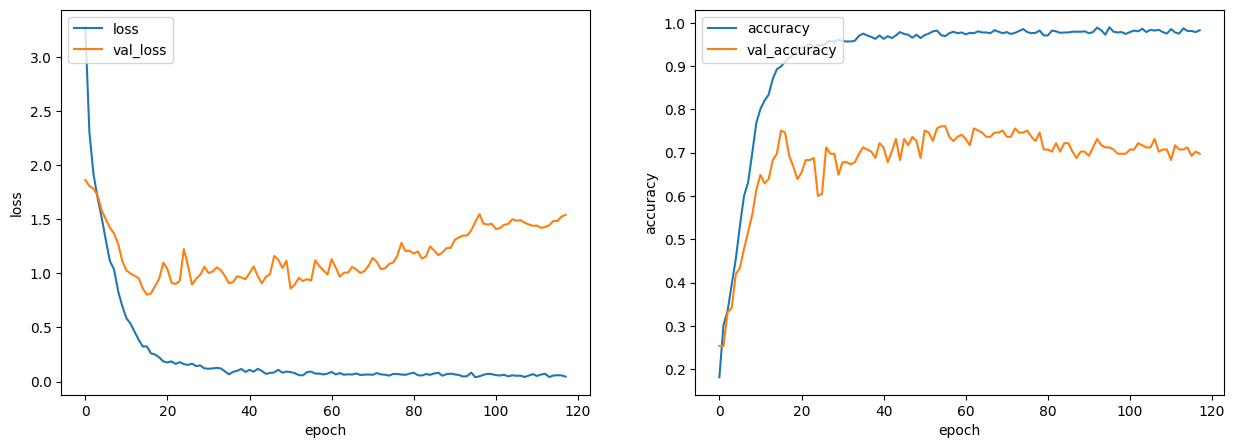

In [225]:
display_learning_curve(history)

In [226]:
_, test_accuracy = baseline_model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {round(test_accuracy * 100, 1)}%')

Test accuracy: 73.3%


In [227]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []

    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)

        instances.append(instance)

    return np.array(instances)

def display_class_probabilities(probabilities):
    for insrance_idx, probs in enumerate(probabilities):
        print(f'Instance {insrance_idx + 1}:')
        for class_idx, prob in enumerate(probs):
            print(f'- {class_values[class_idx]}: {round((prob * 100), 2)}%')


new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Instance 1:
- Case_Based: 0.07000000029802322%
- Genetic_Algorithms: 4.909999847412109%
- Neural_Networks: 54.61000061035156%
- Probabilistic_Methods: 3.940000057220459%
- Reinforcement_Learning: 22.979999542236328%
- Rule_Learning: 2.130000114440918%
- Theory: 11.359999656677246%
Instance 2:
- Case_Based: 0.10000000149011612%
- Genetic_Algorithms: 0.5899999737739563%
- Neural_Networks: 98.87999725341797%
- Probabilistic_Methods: 0.1899999976158142%
- Reinforcement_Learning: 0.009999999776482582%
- Rule_Learning: 0.019999999552965164%
- Theory: 0.20999999344348907%
Instance 3:
- Case_Based: 0.20000000298023224%
- Genetic_Algorithms: 84.5199966430664%
- Neural_Networks: 12.670000076293945%
- Probabilistic_Methods: 0.5299999713897705%
- Reinforcement_Learning: 0.5099999904632568%
- Rule_Learning: 0.009999999776482582%
- Theory: 1.559999942779541%
Instance 4:
- Case_Based: 0.009999999776482582%
- Genetic_Algorithms: 0.20999999344348907%
- Neural_Netw

In [228]:

#preparing the data for the graph model

#creates a sparse adjacency metrix of shape [2, num edges]
edges = citations[['source', 'target']].to_numpy().T

#create the array of edge weights of ones
edge_weights = tf.ones(shape=edges.shape[1])

#create the feature array for the model of shape [num nodes, num features]
node_features = tf.cast(
    papers.sort_values('paper_id')[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

#create the graph info tuple
graph_info = (node_features, edges, edge_weights)

print('Edges shape: ', edges.shape)
print('Nodes shape: ', node_features.shape)

Edges shape:  (2, 5429)
Nodes shape:  (2708, 1433)


In [229]:
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs


    for units in hidden_units:
        x = layers.GRU(
            units=units,
            activation='tanh',
            recurrent_activation='sigmoid',
            return_sequences=True,
            dropout=dropout_rate,
            return_state=False,
            recurrent_dropout=dropout_rate,

        )(x)

    return keras.Model(inputs=inputs, outputs=x)

class GraphConvLayer(layers.Layer):
    def __init__(self,
                 hidden_units,
                 dropout_rate=0.2,
                 aggregation='mean',
                 combination_type='concat',
                 normalization=False,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.aggregation = aggregation
        self.combination_type = combination_type
        self.normalization = normalization

        self.ffn_prepare = ffn(hidden_units, dropout_rate)
        if self.combination_type == 'gru':
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = ffn(hidden_units, dropout_rate)


    def prepare(self, node_representation, weights=None):
        messages = self.ffn_prepare(node_representation)

        if weights is not None:
            messages = messages * tf.expand_dims(weights, axis=-1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_representation):
        num_nodes = node_representation.shape[0]
        print(self.aggregation)
        if self.aggregation == "sum":
            aggregated_messages = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation == "mean":
            aggregated_messages = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation == "max":
            aggregated_messages = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else: raise ValueError(f'Unknown aggregation type: {self.aggregation}')

        return aggregated_messages

    def update(self, node_repesemtation, aggregated_messages):

        if self.combination_type == 'gru':
            #create a sequence of two elements for the GRU layer
            h = tf.stack([node_repesemtation, aggregated_messages], axis=1)
        elif self.combination_type == 'concat':
            h = tf.concat([node_repesemtation, aggregated_messages], axis=1)
        elif self.combination_type == 'add':
            h = node_repesemtation + aggregated_messages
        else:
            raise ValueError(f'Unknown combination type: {self.combination_type}')

        node_embeding = self.update_fn(h)
        if self.combination_type == 'gru':
            node_embeding = tf.unstack(node_embeding, axis=1)[-1]

        if self.normalization:
            node_embeding = tf.nn.l2_normalize(node_embeding, axis=1)
        return node_embeding

    def call(self, inputs):
        node_repesentation, edges, edge_weights = inputs

        node_indices, neighbors_indices = edges[0], edges[1]

        neighbour_representation = tf.gather(node_repesentation, neighbors_indices)

        neighbour_massages = self.prepare(neighbour_representation, edge_weights)

        aggregated_messages = self.aggregate(
            node_indices, neighbour_massages, node_repesentation
        )

        return self.update(node_repesentation, aggregated_messages)




In [230]:
class GNNNodeClassification(tf.keras.Model):
    def __init__(self,
                 graph_info,
                 num_classes,
                 hidden_units,
                 aggregation_type="mean",
                 combination_type='concat',
                 dropout_rate=0.2,
                 normalize=True,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)

        node_features, edges, edge_weights = graph_info

        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights

        self.preprocess = ffn(hidden_units, dropout_rate, name=f'preprocess')

        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])

        self.edge_weights / tf.math.reduce_sum(self.edge_weights)


        self.conv1 = GraphConvLayer(hidden_units, dropout_rate,
                                    aggregation=aggregation_type,
                                    combination_type=combination_type,
                                    normalization=normalize,
                                    name='graph_conv1')

        self.conv2 = GraphConvLayer(hidden_units, dropout_rate,
                                    aggregation=aggregation_type,
                                    combination_type=combination_type,
                                    normalization=normalize,
                                    name='graph_conv2')
        self.postprocess = ffn(hidden_units, dropout_rate, name=f'postprocess')
        self.compute_logits = layers.Dense(num_classes, name='logits')



    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x + x1

        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x + x2

        x = self.postprocess(x)

        print(input_node_indices)
        node_embedding = tf.gather(x, input_node_indices)

        return self.compute_logits(node_embedding)



In [231]:
gnn_model = GNNNodeClassification(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name='gnn_model',
)

In [232]:
incides = np.array([1, 10, 100])
print(gnn_model(incides))


mean
mean
mean
mean
tf.Tensor([  1  10 100], shape=(3,), dtype=int64)
mean
mean
tf.Tensor([  1  10 100], shape=(3,), dtype=int64)
tf.Tensor(
[[-0.01154456 -0.15625466 -0.09331936  0.07449882 -0.03082904  0.0175763
  -0.04479474]
 [-0.05369596 -0.13478784 -0.06175599  0.05723793  0.05441631  0.00245244
  -0.04010678]
 [ 0.06909241 -0.05588698  0.08709943 -0.02239416 -0.09825878  0.10551843
   0.06322876]], shape=(3, 7), dtype=float32)


In [233]:
gnn_model.summary()

Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ (2708, 32)             │        52,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ (2708, 32)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (3, 7)                 │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,179 (262.42 KB)

 Trainable params: 63,481 (247.97 KB)

 Non-trainable params: 3,698 (14.45 KB)

In [234]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
mean
mean
Tensor("data:0", shape=(None,), dtype=int64)
mean
mean
Tensor("data:0", shape=(None,), dtype=int64)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.2069 - loss: 1.9127mean
mean
Tensor("data:0", shape=(None,), dtype=int64)
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2139 - loss: 1.9087 - val_accuracy: 0.2634 - val_loss: 1.8535
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2844 - loss: 1.8148 - val_accuracy: 0.3415 - val_loss: 1.7140
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5199 - loss: 1.4297 - val_accuracy: 0.5073 - val_loss: 1.3842
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6146 - loss: 1.0262 - val_accuracy: 0.6927 - val_loss: 0.9848
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8157 - loss: 0.6274 - val_accuracy: 0.7415 - val_loss: 0.7626
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8904 - loss: 0.3458 - val_accuracy: 0.7610 - val_loss: 0.8512
Epoch 7/3

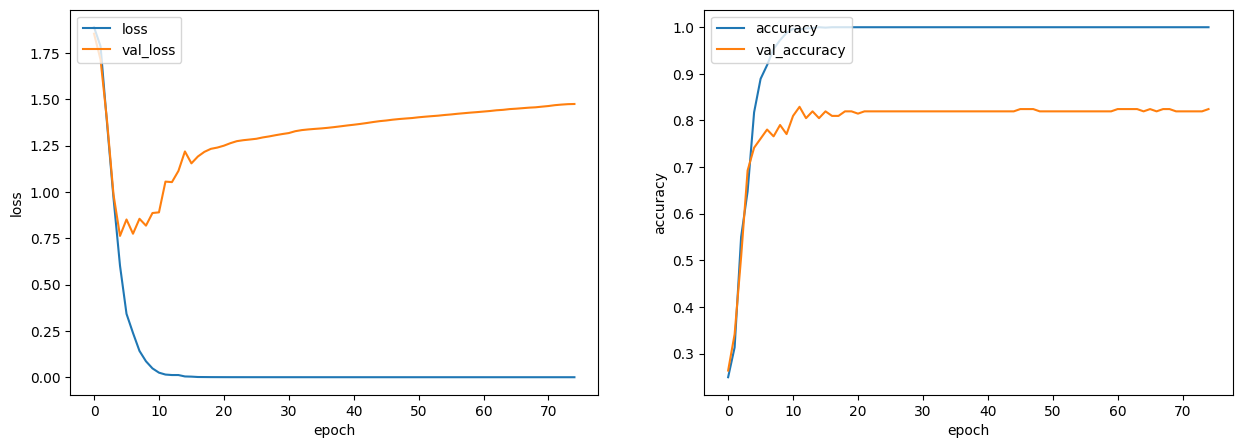

In [235]:
display_learning_curve(history)

In [236]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {round(test_accuracy * 100, 2)}%')

Test accuracy: 76.99%


In [237]:
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])

new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []


for subject_idx, group in papers.groupby('subject'):
    subject_papers = list(group.paper_id)
    selected_paper_indices1 = np.random.choice(subject_papers, 5)

    selected_paper_indices2 = np.random.choice(subject_papers, 2)

    selected_paper_indices = np.concatenate([selected_paper_indices1, selected_paper_indices2])

    citing_paper_index = new_node_indices[subject_idx]
    for cited_paper_index in selected_paper_indices:
        new_citations.append([cited_paper_index, cited_paper_index])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)



In [238]:
print('orginal node features shape: ', gnn_model.node_features.shape)
print('original edge shape: ', gnn_model.edges.shape)

gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])

print('new node features shape: ', gnn_model.node_features.shape)
print('new edges shape: ' , gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

orginal node features shape:  (2708, 1433)
original edge shape:  (2, 5429)
new node features shape:  (2715, 1433)
new edges shape:  (2, 5478)
mean
mean
Tensor("data:0", shape=(7,), dtype=int32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Instance 1:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.0%
- Neural_Networks: 99.93000030517578%
- Probabilistic_Methods: 0.009999999776482582%
- Reinforcement_Learning: 0.05000000074505806%
- Rule_Learning: 0.0%
- Theory: 0.0%
Instance 2:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.0%
- Neural_Networks: 99.91999816894531%
- Probabilistic_Methods: 0.019999999552965164%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.05000000074505806%
Instance 3:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.009999999776482582%
- Neural_Networks: 99.56999969482422%
- Probabilistic_Methods: 0.009999999776482582%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.4000000059604645%
Instance 4:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.0%
- Neural_Networ